# Navigation

---
**Author: Jason Zeng**

**Date: April 24, 2020**

We will use Deep Q-Network (DQN) to train an agent to navigate and collect bananas in a large, square-shaped space. 

A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to:

- 0 - move forward.
- 1 - move backward.
- 2 - turn left.
- 3 - turn right.

The task is episodic, and in order to solve the environment, the agent must get an average score > 13 over some episodes.

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


When finished, you can close the environment.

In [6]:
# env.close()

### 4. Train Agent with DQN

Deep Q-Learning Algorithm was introduced in the paper titled [Human-level control through deep reinforcement learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). Its main idea can be described as follows:

```
Initialize replay memory D with capacity N
Initialize action-value function q with random weights w
Initialize target action-value weights w- <-- w
for episode e <-- 1 to M
    Initial input frame x_1
    Prepare initial state S <-- phi(<x_1>)
    for time step t <-- 1 to T:
        # SAMPLE
        Choose action A from state S using policy pi <-- e-Greedy(q(S,A,w))
        Take action A, observe reward R_t and next input frame x_{t+1}
        Prepare next state S' <-- phi(<x_{t-2}, x_{t-1}, x_{t}, x_{t+1}>)
        Store experience tuple (S, A, R, S') in replay memory D
        S <-- S'
        
        # LEARN
        Obtain random minibatch of tuples(s_j, a_j, r_j, s_{j+1}) from D
        Set target y_j = r_j + gamma * max_a q(s_{j+1}, a, w-)
        Update: dW = alpha* (y_j - q(s_j, a_j, w)) * D_w q(s_j, a_j, w)
        Every C steps, reset: w- <-- w
```

There are also several variants of DQN improvements, including **_Double DQN_**, **_Prioritized Experience Replay_**, **_Dueling DQN_**.

Note: 
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

#### 4.1 Model Stucture

A few words on NN structure:
- A two-hidden-layer NN is used to generate action-value function. 
- Input dimension is 37, corresponding to 37 states. 
- Each hidden layer has 64 nodes.
- 4 output nodes for to 4 actions [0, 1, 2, 3]. 
- Activation function ReLU is used in all layers.

Summary of key model parameters:
```
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
ALPHA = 0.4             # prioritization level (ALPHA=0 is uniform sampling so no prioritization)
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
```

#### 4.2 Function Definition

In [6]:
# define action wrapper function
def action_wrap(action):
    """action wrapper for environment
    
    Params
    ======
        action (int): action to take
     
    Return
    ======
        Outcome from action in tuple: (next_state, reward, done)
    """
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    return (next_state, reward, done)              # return tuple (nex_state, reward, done)

# define DQN training structure
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
        priorReplay=False, beta_start=0.4, name="dqn-default", log=True):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        priorReplay (boolean): is prioritized replay required
        beta_start (float): starting value of importance sampling (when prioritized replay active)
        name (string): name of checkpoint file when environment solved
        log (boolean): logging to monitor progress
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    beta = lambda episode: min(1.0, beta_start + episode * (1.0 - beta_start) / n_episodes/2)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations[0]            
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done = action_wrap(action)
            # for replay
            if priorReplay: 
                agent.step(state, action, reward, next_state, done, beta(i_episode))
            else:
                agent.step(state, action, reward, next_state, done)
                
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if log:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            if log:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        if np.mean(scores_window)>=13.0:
            if log:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)), end="\n")
            
            checkpoint = {
                'state_size': state_size,
                'action_size': action_size,
                'hidden_layers': [each.out_features for each in agent.qnetwork_local.hidden_layers],
                'state_dict': agent.qnetwork_local.state_dict(),
                'scores': scores}
            
            torch.save(checkpoint, 'checkpoint-' + name + '.pth')                
            break  # stop training when mean score >=13
            
    return scores

#### 4.3 Training

In [20]:
# load environment and packages
import numpy as np
import pandas as pd
import random
import torch
from collections import deque

import matplotlib.pyplot as plt
from tqdm import tqdm
from unityagents import UnityEnvironment

# use Vanilla for this exercise
from dqn_agent import Vanilla  #, Double, PrioritizedReplay
# to keep workstation from idle
from workspace_utils import active_session  

In [21]:
# reset the environment with train_mode=True
env_info =  env.reset(train_mode=True)[brain_name]
# call simple Vanilla, hidden layers = [64, 64]
agent = Vanilla(state_size=state_size, action_size=action_size, hidden_layers=[64, 64], seed=0)

In [22]:
%time scores = dqn(name="dqn")

Episode 100	Average Score: 0.42
Episode 200	Average Score: 3.60
Episode 300	Average Score: 6.77
Episode 400	Average Score: 9.59
Episode 500	Average Score: 12.16
Episode 525	Average Score: 13.03
Environment solved in 425 episodes!	Average Score: 13.03
CPU times: user 8min 55s, sys: 1min 4s, total: 10min
Wall time: 4h 21min 6s


In [73]:
import matplotlib

# load checkpoint if needed
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return (checkpoint['state_size'], checkpoint['action_size'], 
            checkpoint['hidden_layers'], checkpoint['state_dict'], checkpoint['scores'])

# define moving average function to be used in plotting
def moving_average(x, n=3) :
    ret = np.cumsum(x, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# plot score, together with moving average
def plot_scores(scores, smooth_window=30):
    scores_smoothed = moving_average(scores, smooth_window)
    # config the plot
    fig = plt.figure(figsize=(10, 8))
    matplotlib.rcParams.update({'font.size': 16})
    #ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, linewidth=2, alpha=0.4, color='green', label='individual')
    plt.plot(np.arange(len(scores))[smooth_window-1:,], scores_smoothed, linewidth=1.5, alpha=1, color='blue', label='average')
    plt.legend(bbox_to_anchor=(0.05, 0.95), loc='upper left', borderaxespad=0.)
    plt.ylabel('Score')
    plt.xlabel('Episode Number')
    plt.show()
    return fig


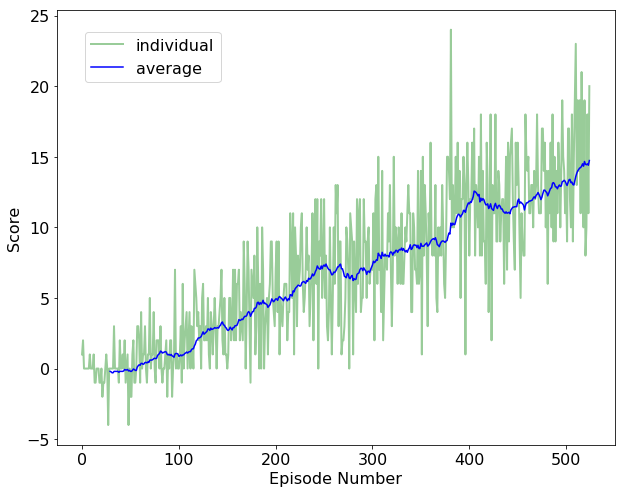

In [74]:
_, _, _, _, list_dqn_scores = load_checkpoint('checkpoint-dqn.pth')
figure = plot_scores(list_dqn_scores)

### 5. Summary and Discussion
In this notebook, we applied DQN to train agent for Banana navigation task. An average score of 13.03 for 100 episodes is achieved with only 425 training episodes.  

A few ways to further improve:
- Hyperparameter tuning, including $\epsilon$-decay rate, discount factor, update frequency etc.
- Apply DQN improvements, including **_Double DQN_**, **_Prioritized Experience Replay_**, **_Dueling DQN_**.